[View in Colaboratory](https://colab.research.google.com/github/plushvoxel/Project-Lernende-Agenten-colab/blob/master/WorkingVersion1.0.ipynb)

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Creating a NN

## Setup

First, let's load and prepare the data.

In [0]:
from __future__ import print_function

import math
from urllib import request
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
from google.colab import files
from tarfile import open as taropen
from struct import unpack


In [0]:
training_set_size = 100 #@param {type:"slider", min:1, max:3000, step:1}
validating_set_size = 10 #@param {type:"slider", min:1, max:1000, step:1}
test_set_size = 10 #@param {type:"slider", min:1, max:1000, step:1}
learning_rate = 0.3 #@param ["3", "1", "0.3", "0.1", "0.03", "0.01", "0.003", "0.001", "0.0003", "0.0001"] {type:"raw"}
activation_function = "RELU" #@param ["RELU", "Sigmoid", "Tanh"]
regression = "None" #@param ["None", "L1", "L2"]
regression_rate = 3 #@param ["3", "1", "0.3", "0.1", "0.03", "0.01", "0.003", "0.001"] {type:"raw"}
steps = 20 #@param {type:"slider", min:1, max:100, step:1}
batch_size = 5 #@param {type:"slider", min:1, max:20, step:1}
model = [2048, 500]

In [141]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

request.urlretrieve("https://github.com/plushvoxel/Project-Lernende-Agenten-Data-Generator/blob/master/iq.tar?raw=true", "iq.tar")
tar = taropen("iq.tar")

data = dict()
MODKEY = "mod"

for member in tar.getmembers():
  
  modulation = member.name[3:5]
  if modulation == "am":
    modulation = 1
  else:
    modulation = 0
  if not MODKEY in data:
    data[MODKEY] = [modulation]
  else:
    data[MODKEY].append(modulation)
  with tar.extractfile(member) as f:
    buffer = f.read()
    num_floats = len(buffer)//4
    floats = unpack("f"*num_floats, buffer)
    i = floats[0::2]
    q = floats[1::2]
    for j in range(len(i)):
      ikey = "i{:05d}".format(j)
      qkey = "q{:05d}".format(j)
      if not ikey in data:
        data[ikey] = [i[j]]
      else:
        data[ikey].append(i[j])
      if not qkey in data:
        data[qkey] = [q[j]]
      else:
        data[qkey].append(q[j])
        
signal_dataframe = pd.DataFrame(data=data)
signal_dataframe = signal_dataframe.reindex(
    np.random.permutation(signal_dataframe.index))
print(signal_dataframe)

    i00000  i00001  i00002  i00003  i00004  i00005  i00006  i00007  i00008  \
56    -0.2     0.7     1.0     0.5    -0.4    -1.0    -0.7     0.1     0.9   
6      0.0     0.0     0.0    -0.0     0.0     0.0     0.0     0.0    -0.0   
46    -0.0     0.0    -0.0     0.0    -0.0    -0.0     0.0     0.0    -0.0   
98     0.3     1.0    -0.9    -0.6    -0.4     0.1    -0.5    -0.9     0.2   
12     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
21     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
36     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
70     1.0     0.9     1.0    -0.9     0.5     0.7    -0.7     0.1    -0.8   
37     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
34     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

    i00009   ...    q02038  q02039  q02040  q02041  q02042  q02

In [0]:
def preprocess_features(signal_dataframe):
  """Prepares input features from California housing data set.

  Args:
    signal_dataframe: A Pandas DataFrame expected to contain data
      from the Radio Signal data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = signal_dataframe.loc[:,'i00000':]
  processed_features = selected_features.copy()
  
  print(signal_dataframe.shape[0])
  return processed_features

def preprocess_targets(signal_dataframe):
  """Prepares target features (i.e., labels) from Radio signal data set.

  Args:
    signal_dataframe: A Pandas DataFrame expected to contain data
      from the Radio signal data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  output_targets[MODKEY] = signal_dataframe[MODKEY]
  return output_targets

In [143]:
training_examples = preprocess_features(signal_dataframe.head(training_set_size))
training_examples.describe()

100


,i00000,i00001,i00002,i00003,i00004,i00005,i00006,i00007,i00008,i00009,...,q02038,q02039,q02040,q02041,q02042,q02043,q02044,q02045,q02046,q02047
count,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
mean,0.4,0.4,0.5,0.5,0.5,0.5,0.4,0.4,0.4,0.4,...,0.0,0.0,-0.0,-0.0,-0.1,0.0,0.0,-0.0,0.0,0.1
std,0.7,0.8,0.7,0.7,0.6,0.7,0.7,0.7,0.7,0.7,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
25%,-0.1,-0.5,0.0,0.0,0.1,0.0,-0.1,0.0,-0.2,-0.0,...,-0.1,-0.0,-0.1,-0.0,-0.1,-0.0,-0.0,-0.1,-0.0,-0.0
50%,0.9,0.9,1.0,1.0,1.0,0.9,0.9,1.0,0.9,0.9,...,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0
75%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.1,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [144]:
training_targets = preprocess_targets(signal_dataframe.head(training_set_size))
training_targets.describe()

,mod
count,100.0
mean,0.5
std,0.5
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


In [145]:
validation_examples = preprocess_features(signal_dataframe.tail(test_set_size))
validation_examples.describe()

10


,i00000,i00001,i00002,i00003,i00004,i00005,i00006,i00007,i00008,i00009,...,q02038,q02039,q02040,q02041,q02042,q02043,q02044,q02045,q02046,q02047
count,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
mean,0.9,0.5,0.7,0.6,0.5,0.8,0.6,0.5,0.6,0.5,...,0.1,-0.1,0.1,0.1,-0.1,0.1,0.1,0.2,0.0,-0.1
std,0.3,0.8,0.6,0.8,0.7,0.3,0.7,0.7,0.7,0.8,...,0.4,0.5,0.4,0.5,0.6,0.2,0.3,0.6,0.4,0.4
min,0.1,-1.0,-1.0,-0.9,-0.7,0.1,-0.7,-0.9,-0.8,-1.0,...,-0.3,-1.0,-0.5,-0.9,-1.0,-0.2,-0.5,-1.0,-0.7,-0.8
25%,1.0,0.2,1.0,0.7,0.3,0.8,0.8,0.1,0.8,0.3,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.3
50%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0
75%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.0,-0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.7,0.9,0.9,0.9,0.5,0.7,1.0,0.9,0.8


In [146]:
validation_targets = preprocess_targets(signal_dataframe.tail(test_set_size))
validation_targets.describe()

,mod
count,10.0
mean,0.6
std,0.5
min,0.0
25%,0.0
50%,1.0
75%,1.0
max,1.0


## Building a Neural Network

The NN is defined by the [DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor) class.

Use **`hidden_units`** to define the structure of the NN.  The `hidden_units` argument provides a list of ints, where each int corresponds to a hidden layer and indicates the number of nodes in it.  For example, consider the following assignment:

`hidden_units=[3,10]`

The preceding assignment specifies a neural net with two hidden layers:

* The first hidden layer contains 3 nodes.
* The second hidden layer contains 10 nodes.

If we wanted to add more layers, we'd add more ints to the list. For example, `hidden_units=[10,20,30,40]` would create four layers with ten, twenty, thirty, and forty units, respectively.

By default, all hidden layers will use ReLu activation and will be fully connected.

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `signal_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `signal_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `signal_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `signal_dataframe` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets[MODKEY], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets[MODKEY], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets[MODKEY], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

Training model...
RMSE (on training data):
  period 00 : 1.46
  period 01 : 2.02
  period 02 : 1.81
  period 03 : 1.25
  period 04 : 1.32
  period 05 : 1.36
  period 06 : 2.66
  period 07 : 8.25
  period 08 : 3.21
  period 09 : 2.94
Model training finished.
Final RMSE (on training data):   2.94
Final RMSE (on validation data): 1.80


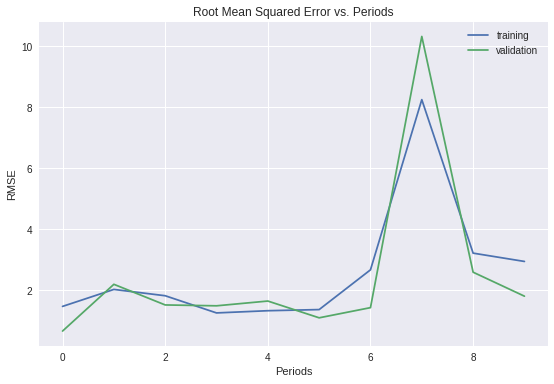

In [150]:
dnn_regressor = train_nn_regression_model(
    learning_rate=learning_rate,
    steps=steps,
    batch_size=batch_size,
    hidden_units=model,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)